In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


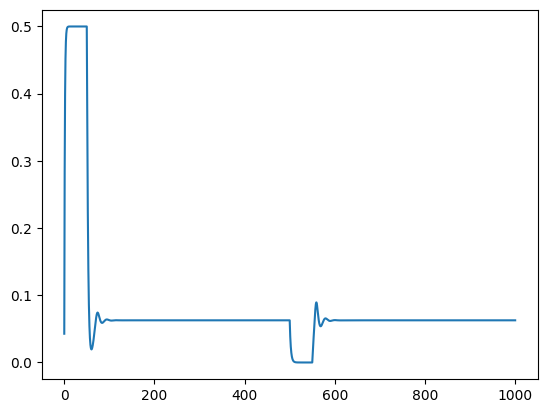

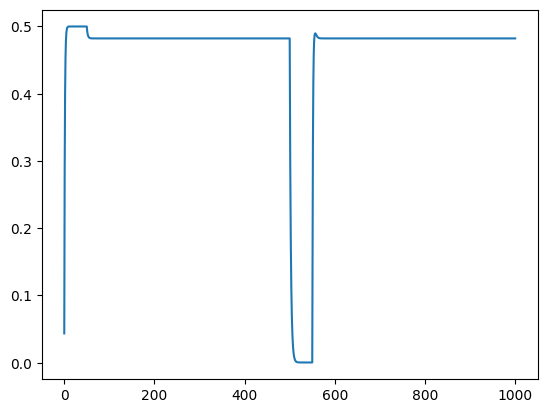

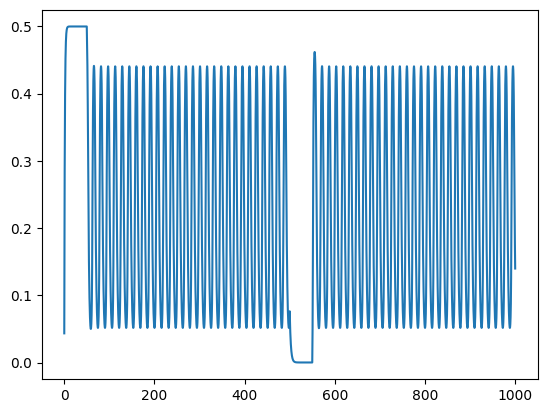

period =  15.67777777777778


In [3]:
comp_points = [[1., 0.5], [3., 0.5], [2., 0.5]]

N = 1

colors = []
n = 0
for col in mcolors.TABLEAU_COLORS:
    colors.append(col)
    n += 1
    if n >= N: break

model = WCModel()

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params.signalV = 1.

zero_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
rect_input = np.vstack( (zero_input)*2 )
rect_input[0,:500] = 5.
rect_input[0,5000:5500] = -5.

for p in comp_points:
    model.params["exc_ext"] = p[0] + rect_input[0,:]
    model.params["inh_ext"] = p[1]
    model.run()

    for n in range(N):
        plt.plot(model.t, model.exc[n,:], color=colors[n])
    plt.show()

    if p[0] == 2.:

        peaks = scipy.signal.find_peaks(model.exc[0,2000:5000])[0]
        plist = []
        for pind in range(1, len(peaks)):
            plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

        period = np.mean(plist)
        print("period = ", period)


In [5]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

duration = 200.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

print(zero_input0.shape, zero_input.shape, zero_control.shape)

w2_array = [1e-5]

results = dict()
results["controls"] = [ None, None, None ]
target_array = [0.9*period]

(1, 2001) (1, 2, 2001) (1, 2, 2001)


In [54]:
it = 1
pr = np.arange(0,101,1)
maxstr = 10.
nmaxdel = model.getMaxDelay()

init_control = zero_control.copy()

In [55]:
target_period = target_array[0]
w2 = w2_array[0]

pind = 0

print("pind = ", pind)

p = comp_points[pind]

testd = 1000.
model.params.duration = testd
test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
model.params["exc_ext"] = test_input + p[0]
model.params["inh_ext"] = test_input + p[1]
model.run()

einit = np.zeros((N, nmaxdel+1))
iinit = np.zeros((N, nmaxdel+1))

for n in range(N):
    einit[n,:] = model.exc[n,-1]
    iinit[n,:] = model.inh[n,-1]

model.params.duration = duration
model.params["exc_ext"] = zero_control[:,0,:] + p[0]
model.params["inh_ext"] = zero_control[:,0,:] + p[1]
model.params["exc_init"] = einit
model.params["inh_init"] = iinit
model.run()

i00 = 0
int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
while int0 > 250:
    i00 += 1
    int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)  

pind =  0


In [60]:
model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
model_controlled.maximum_control_strength = maxstr
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = w2
model_controlled.weights["w_f"] = 1.

if type(results["controls"][pind]) != type(None):
    model_controlled.control = results["controls"][pind].copy()
    model_controlled.update_input()

Optimal control with target oscillation period


In [61]:
model_controlled.optimize(it)

Compute control for a deterministic system
Cost in iteration 0: -1.284757520739065e-18
Cost in iteration 1: -0.000994317729189165
Final cost : -0.000994317729189165


In [62]:
model_controlled.optimize(it)

Compute control for a deterministic system
Cost in iteration 0: -0.000994317729189165


SystemError: _PyEval_EvalFrameDefault returned a result with an error set

In [59]:
model_controlled.optimize(it)

Compute control for a deterministic system
Cost in iteration 0: -0.07009904788912262
Cost in iteration 1: -0.19743236470287906
Final cost : -0.19743236470287906


In [50]:
%prun model_controlled.optimize(it)

Compute control for a deterministic system
Cost in iteration 0: -0.000994317729189165
Cost in iteration 1: -0.07009904788912262
Final cost : -0.07009904788912262
 

         25987358 function calls (24290392 primitive calls) in 29.126 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    63747   16.609    0.000   17.499    0.000 ffi.py:149(__call__)
816203/147569    0.528    0.000    0.763    0.000 ir.py:313(_rec_list_vars)
  5113697    0.431    0.000    0.542    0.000 {built-in method builtins.isinstance}
794360/371202    0.373    0.000    1.363    0.000 {method 'format' of 'str' objects}
   165009    0.345    0.000    0.673    0.000 values.py:232(_set_name)
     2017    0.290    0.000    0.290    0.000 {built-in method numpy.fft._pocketfft_internal.execute}
     7986    0.259    0.000    0.309    0.000 instructions.py:475(__init__)
    18706    0.255    0.000    0.261    0.000 types.py:444(elements)
    27622    0.244    0.000    0.250    0.000 os.py:754(encode)
    36898    0.242    0.000    0.247    0.000 ir.py:379(__getattr__)
     3094    0.228    0.000    0.251    0.000 models.py:

In [48]:
%prun model_controlled.optimize(it)

Compute control for a deterministic system
Cost in iteration 0: -1.284757520739065e-18
Cost in iteration 1: -0.000994317729189165
Final cost : -0.000994317729189165
 

         35190 function calls (35158 primitive calls) in 274.583 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  272.033  272.033  272.425  272.425 cost_functions.py:88(derivative_accuracy_cost)
       16    2.132    0.133    2.135    0.133 cost_functions.py:15(accuracy_cost)
     2017    0.293    0.000    0.293    0.000 {built-in method numpy.fft._pocketfft_internal.execute}
     2017    0.039    0.000    0.062    0.000 helper.py:123(fftfreq)
     2049    0.012    0.000    0.012    0.000 {built-in method numpy.empty}
     2051    0.010    0.000    0.010    0.000 serialize.py:140(_numba_unpickle)
     4050    0.010    0.000    0.010    0.000 {built-in method numpy.arange}
     2017    0.008    0.000    0.312    0.000 _pocketfft.py:122(fft)
     2017    0.007    0.000    0.302    0.000 _pocketfft.py:49(_raw_fft)
2387/2355    0.006    0.000    0.320    0.000 {built-in method numpy.core._multiarray_umath.implement_a

In [22]:
results["controls"][pind] = model_controlled.control.copy()

In [23]:
with open('osc_1n.pickle', 'wb') as f:
    pickle.dump(results, f)

In [24]:
with open('osc_1n.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

results = res_read.copy()

dict_keys(['controls', 'periods', 'timings'])


In [25]:
xl = [ ["Down F", "Up F", "Osc F"], ["Down AC", "Up AC", "Osc AC"], ["Down Phase", "Up Phase", "Osc Phase"], ["Down Var", "Up Var", "Osc Var"] ]

TypeError: 'NoneType' object is not subscriptable

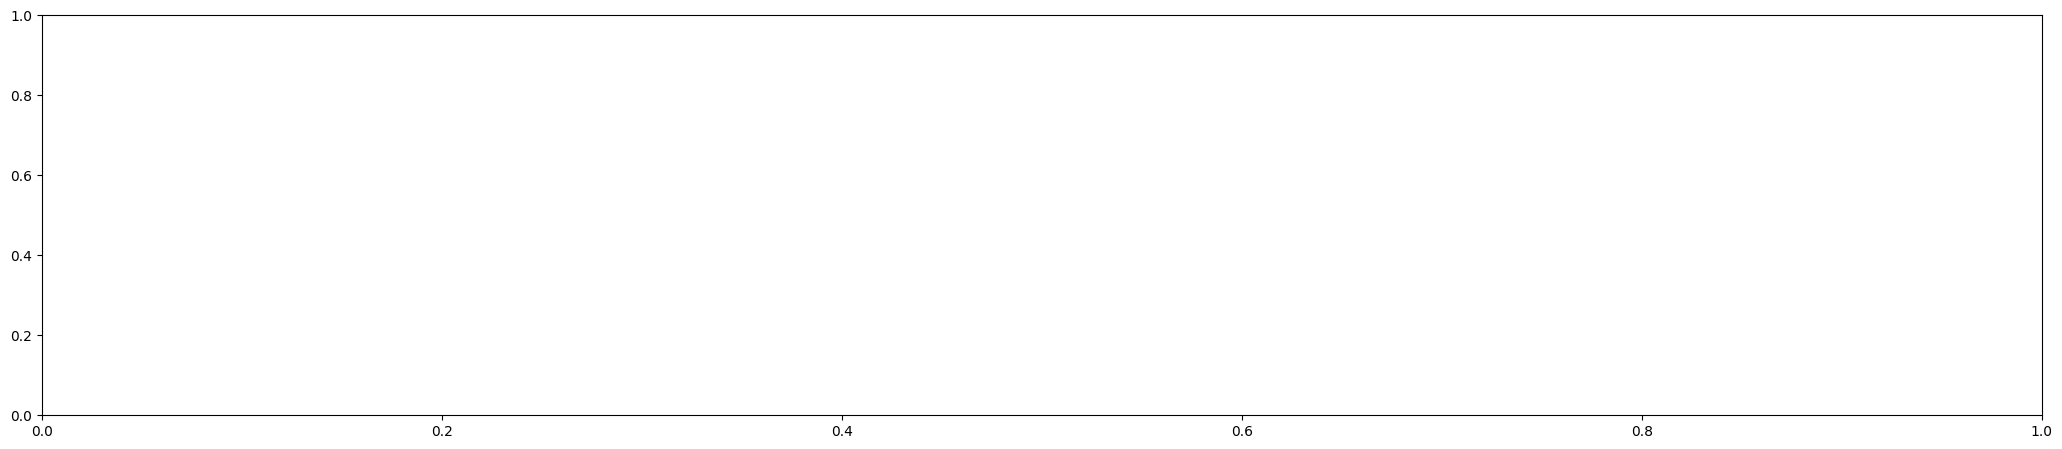

In [26]:
for iw in range(len(w2_array)):
    ydata = []
    xlabels = []
    fig = plt.figure(figsize =(20, 4))
    ax = fig.add_axes([0, 0, 1, 1])

    xpos = 0

    for imet in range(4):

        for pind in range(len(comp_points)):

            for itar in range(len(target_array)):

                if imet == 3:
                    if itar != 1:
                        continue

                target_period = target_array[itar]
                #xpos = 15*imet + 5*pind + itar

                if imet != 3:
                    if itar != 0:
                        xlabels.append("")
                    else:
                        xlabels.append(xl[imet][pind])
                if imet == 3:
                    xlabels.append(xl[imet][pind])

                data = results["periods"][pind][itar][imet][iw]
                ydata_ = []
                
                if data is None:
                    ydata.append(ydata_)
                    continue

                n_datapoints = 0

                for n in range(N):
                    n_datapoints += len(data[n])
                    
                    if len(data[n]) != 0:
                        for dpoint in data[n]:
                            ax.plot(xpos+1, dpoint, marker="x", color=colors[n])
                            ydata_.append(dpoint)

                ydata.append(ydata_)

                ax.text(xpos+1, 1, str(n_datapoints), horizontalalignment='center', verticalalignment='center')
                if imet != 3: ax.hlines(target_period, xpos+0.5, xpos+1.5, linestyle=":", color="red", linewidth =3)

                xpos += 1


    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.vlines([15.5, 30.5, 45.5], 0., 2.*period, color="grey")
    ax.hlines(period, 1., len(xlabels), linestyle=":", color="grey",linewidth = 1)
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_ylim(0., 2.*period)
    ax.set_title(r"Period duration, $w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig(os.path.join(dir, "periods_" + str(iw) + ".png"), bbox_inches='tight')